<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C4/C4/W1/ungraded_labs/C4_W1_Lab_1_tfserving_hello_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

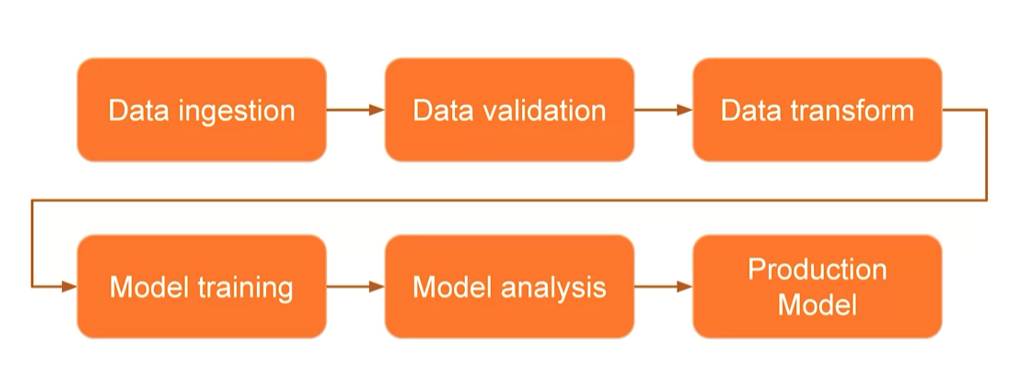

# Getting Started with TensorFlow Serving

In this notebook you will serve your first TensorFlow model with TensorFlow Serving. We will start by building a very simple model to infer the relationship:

$$
y = 2x - 1 
$$

between a few pairs of numbers. After training our model, we will serve it with TensorFlow Serving, and then we will make inference requests.

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

## Setup

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import os
import json
import tempfile
import requests
import numpy as np

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)

## Add TensorFlow Serving Distribution URI as a Package Source

We will install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) (the default Debian package manager) since Google's Colab runs in a Debian environment. 

Before we can install TensorFlow Serving, we need to add the `tensorflow-model-server` package to the list of packages that Aptitude knows about. Note that we're running as root.

**Note**: This notebook is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving. The Docker Engine is available for a variety of Linux platforms, Windows, and Mac.

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

## Install TensorFlow Serving

Now that the Aptitude packages have been updated, we can use the `apt-get` command to install the TensorFlow model server.

In [ ]:
!apt-get install tensorflow-model-server

## Create Dataset

Now, we will create a simple dataset that expresses the relationship:

$$
y = 2x - 1 
$$

between inputs (`xs`) and outputs (`ys`).

In [ ]:
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

## Build and Train the Model

We'll use the simplest possible model for this example. Since we are going to train our model for `500` epochs, in order to avoid clutter on the screen, we will use the argument `verbose=0` in the `fit` method. The Verbosity mode can be:

* `0` : silent.

* `1` : progress bar.

* `2` : one line per epoch.

As a side note, we should mention that since the progress bar is not particularly useful when logged to a file, `verbose=2` is recommended when not running interactively (eg, in a production environment).

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])

model.compile(optimizer='sgd',
              loss='mean_squared_error')

history = model.fit(xs, ys, epochs=500, verbose=0)

print("Finished training the model")

Finished training the model


## Test the Model

Now that the model is trained, we can test it. If we give it the value `10`, we should get a value very close to `19`.

In [ ]:
print(model.predict([10.0]))

[[18.980923]]


## Save the Model

To load the trained model into TensorFlow Serving we first need to save it in the [SavedModel](https://www.tensorflow.org/guide/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/serving_config) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [ ]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 56
drwxr-xr-x 2 root root  4096 Jun 16 12:28 assets
-rw-r--r-- 1 root root  3882 Jun 16 12:28 keras_metadata.pb
-rw-r--r-- 1 root root 41768 Jun 16 12:28 saved_model.pb
drwxr-xr-x 2 root root  4096 Jun 16 12:28 variables


## Examine Your Saved Model

We'll use the command line utility `saved_model_cli` to look at the `MetaGraphDefs` and `SignatureDefs` in our SavedModel. The signature definition is defined by the input and output tensors, and stored with the default serving key.

In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_3_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: serving_default_dense_3_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0616 12:28:40.299458 140395015030656 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops

## Run the TensorFlow Model Server

We will now launch the TensorFlow model server with a bash script. We will use the argument `--bg` to run the script in the background.

Our script will start running TensorFlow Serving and will load our model. Here are the parameters we will use:

* `rest_api_port`: The port that you'll use for requests.


* `model_name`: You'll use this in the URL of your requests.  It can be anything.


* `model_base_path`: This is the path to the directory where you've saved your model.

Also, because the variable that points to the directory containing the model is in Python, we need a way to tell the bash script where to find the model. To do this, we will write the value of the Python variable to an environment variable using the `os.environ` function.

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=helloworld \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 4 in a separate thread.


Now we can take a look at the server log.

In [ ]:
!tail server.log

## Create JSON Object with Test Data

We are now ready to construct a JSON object with some data so that we can make a couple of inferences. We will use $x=9$ and $x=10$ as our test data.

In [ ]:
xs = np.array([[9.0], [10.0]])
data = json.dumps({"signature_name": "serving_default", "instances": xs.tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[9.0], [10.0]]}


## Make Inference Request

Finally, we can make the inference request and get the inferences back. We'll send a predict request as a POST to our server's REST endpoint, and pass it our test data. We'll ask our server to give us the latest version of our model by not specifying a particular version. The response will be a JSON payload containing the predictions.

In [ ]:
# if this cell fails execution because of an "...Failed to establish a new connection..." error,
# try replacing in the link below 'localhost' with '127.0.0.1'

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/helloworld:predict', data=data, headers=headers)

print(json_response.text)

{
    "predictions": [[16.9836864], [18.9809227]
    ]
}


We can also look at the predictions directly by loading the value for the `predictions` key.

In [ ]:
predictions = json.loads(json_response.text)['predictions']
print(predictions)

[[16.9836864], [18.9809227]]
